In [455]:
import warnings
warnings.filterwarnings("ignore")

In [456]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, Pool

### Читаем данные

In [457]:
train = []
for z in range(44, -1, -1):
    train.append( pd.read_csv(f"train/train{z}.csv", sep=";", index_col=None, dtype={'PATIENT_SEX':str, 'MKB_CODE':str, 'ADRES':str, 'VISIT_MONTH_YEAR':str, 'AGE_CATEGORY':str, 'PATIENT_ID_COUNT':int}))

test = pd.read_csv(f"prepared_test.csv", sep=";", index_col=None, dtype={'PATIENT_SEX':str, 'MKB_CODE':str, 'ADRES':str, 'VISIT_MONTH_YEAR':str, 'AGE_CATEGORY':str, 'PATIENT_ID_COUNT':int})

In [458]:
len(train)

45

### Юзаем  категориальные фичи для CatBoost

И удялаем численные, которые их заменяют

In [459]:
# for catboost
X, y = [], []
for i in range(45):
    train[i].drop(['MONTH', "AGE", 'YEAR', 'SEX', 'CITY'], axis=1, inplace=True)
    X.append(train[i].drop("PATIENT_ID_COUNT", axis=1))
    y.append(train[i]["PATIENT_ID_COUNT"])
test.drop(['MONTH', "AGE", 'YEAR', 'SEX', 'CITY', "PATIENT_ID_COUNT"], axis=1, inplace=True)

In [460]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

### Обучение Catboost, чтобы достать лучшие признаки

Можно обучать на последних N месяцев

In [487]:
N = len(X) # len(X) - Обучение на всех данных

In [488]:
pool_train = Pool(pd.concat(X[-N:]), pd.concat(y[-N:]), cat_features = ['ADRES', 'VISIT_MONTH_YEAR','PATIENT_SEX', 'MKB_CODE', 'AGE_CATEGORY'])

model = CatBoostRegressor(task_type="GPU")
model.fit(pool_train, verbose=False)

#### С помощью CatBoost достаем самые полезные фичи

<AxesSubplot:>

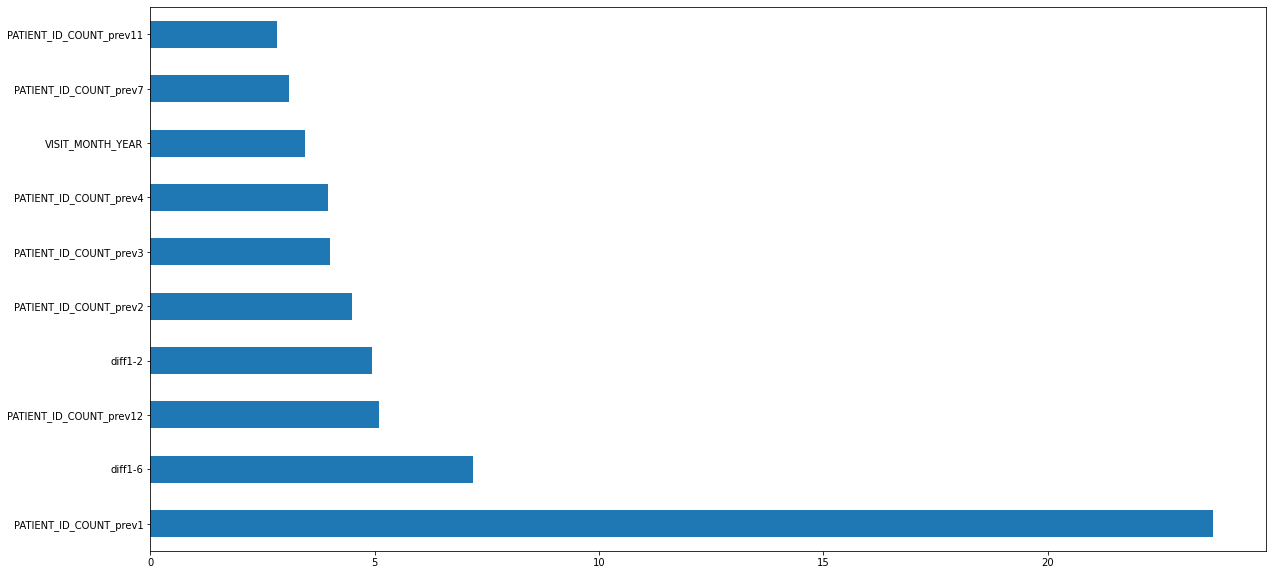

In [489]:
(pd.Series(model.feature_importances_, index=X[0].columns)
   .nlargest(10)
   .plot(kind='barh', figsize=(20, 10)))

In [490]:
best_features = pd.Series(model.feature_importances_, index=X[0].columns).nlargest(10).index

In [491]:
best_features

Index(['PATIENT_ID_COUNT_prev1', 'diff1-6', 'PATIENT_ID_COUNT_prev12',
       'diff1-2', 'PATIENT_ID_COUNT_prev2', 'PATIENT_ID_COUNT_prev3',
       'PATIENT_ID_COUNT_prev4', 'VISIT_MONTH_YEAR', 'PATIENT_ID_COUNT_prev7',
       'PATIENT_ID_COUNT_prev11'],
      dtype='object')

In [492]:
best_linear_features = best_features.drop(['VISIT_MONTH_YEAR'])

In [493]:
best_linear_features

Index(['PATIENT_ID_COUNT_prev1', 'diff1-6', 'PATIENT_ID_COUNT_prev12',
       'diff1-2', 'PATIENT_ID_COUNT_prev2', 'PATIENT_ID_COUNT_prev3',
       'PATIENT_ID_COUNT_prev4', 'PATIENT_ID_COUNT_prev7',
       'PATIENT_ID_COUNT_prev11'],
      dtype='object')

#### Выбираем сколько конкретно фич будем использовать с помощью кросс-валидации для рядов

In [472]:
logs = []
for k in range(1, 10):
    tscv = TimeSeriesSplit(n_splits=42, max_train_size=20)
    score = []
    i = 0
    for tr_index, val_index in tscv.split(X):
        i += 1
        # не очень интересны самые старые предсказания
        if i < 20:
            continue
        X_tr, X_val = pd.concat([X[z] for z in tr_index])[best_linear_features[:k]], pd.concat([X[z] for z in val_index])[best_linear_features[:k]]
        y_tr, y_val = pd.concat([y[z] for z in tr_index]), pd.concat([y[z] for z in val_index])
        model = LinearRegression()
        model.fit(X_tr, y_tr)

        pred = model.predict(X_val)
        score.append(r2_score(y_val, pred))
    
    logs.append(score)

    print("k=", k, " median=", round(np.median(score), 3), " mean=", round(np.mean(score), 3))

k= 1  median= 0.861  mean= 0.747
k= 2  median= 0.846  mean= 0.764
k= 3  median= 0.855  mean= 0.764
k= 4  median= 0.855  mean= 0.764
k= 5  median= 0.853  mean= 0.768
k= 6  median= 0.866  mean= 0.758
k= 7  median= 0.864  mean= 0.754
k= 8  median= 0.847  mean= 0.746
k= 9  median= 0.847  mean= 0.746


### Для борьбы с переобучением использую линейные модели

In [494]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [496]:
k = 6
N = 20 # последние данные больше интересны чем все

In [497]:
best_model = LinearRegression() #
best_model.fit(pd.concat(X[-N:])[best_linear_features[:k]], pd.concat(y[-N:]))
pred = np.round(best_model.predict(test[best_linear_features[:k]])).astype(np.int64)

Модель обучена на N месяцев. Линейная модель при таком кол-ве данных не офервитится, но не учитывает тренд. Предсказывает результаты на уровне (N/2). Поэтому результат нужно домножить на (N/2) трендовых коэффициентов.

In [498]:
import pickle

In [499]:
with open("trend_coefs.pkl", "rb") as fin:
    trend_coefs = pickle.load(fin)

Чтобы стабилизировать домножение используем медиану коэффициентов

In [500]:
mid = np.median(trend_coefs[-N:])
for i in range(N//2):
    pred = np.trunc(mid*pred)

### Сохранение результатов

In [501]:
len(pred)

39373

In [502]:
for i in range(len(pred)):
    if pred[i] < 1:
        pred[i] = 1

In [503]:
from collections import Counter

In [504]:
orig_test = pd.read_csv('test_dataset_test.csv', sep=';', index_col=None, dtype={'PATIENT_SEX':str, 'MKB_CODE':str, 'ADRES':str, 'VISIT_MONTH_YEAR':str, 'AGE_CATEGORY':str})

In [505]:
orig_test["PATIENT_ID_COUNT"] = pred

In [506]:
orig_test.to_csv('LinearK6_TrendN10_result.csv', sep=';', index=None)